# 飞桨学习赛:眼底OCT层分割-2022年12月赛段第2名

---

眼底OCT层分割（GOALS挑战赛任务一）

## 赛题介绍

光学相干断层扫描（OCT）因其无接触、非侵入性的特点，已成为眼部疾病诊疗中的常规检查，可为医生提供视网膜结构图像。与只能提供视网膜表面信息的彩色眼底图像相比，OCT图像可以提供视网膜的横断面信息，因此可以更准确地分析视网膜结构。层的分割和厚度量化对许多视网膜和视神经疾病的诊断有帮助，例如青光眼、黄斑变性或糖尿病性视网膜病变。在青光眼的诊断中，使用OCT比使用眼底彩色图像更容易发现早期病例。本学习赛是环扫OCT图像的层分割任务，目的是确定视网膜神经纤维层、神经节细胞丛层和脉络膜层，这有助于青光眼的诊断和区分。

## 数据集与标签文件

![](https://ai-studio-static-online.cdn.bcebos.com/e8b0f92ba6be435db7412bb04ac976860a575235ed3b40738b58012134a2051a)
![](https://ai-studio-static-online.cdn.bcebos.com/bc95f863929840699a38c53aa4ae6b82e31bfae106ea4d25be8d9812888ab356)

训练集解压文件包含如下:
* Image 原始图片
* Layer_Masks 标签
* Layer_show 可视化图片（训练无需使用）
* License-GOALS-0606.pdf 使用证书

数据集是一个标准的医学影像数据集，医学影像的特点是数据少。很多时候许多图片还是来自于1个病人，并且附加的病人文本信息也作为1个输入，这样的多模态比赛在其他竞赛平台上很常见。另外1个特点是，医学影像多是灰度图。因为人体内是无法直接获取的。早期的机器学习时期就有在医学影像的应用，深度学习火热后，效果远远超越其他方法，已经被验证为一个有效的策略。


# 一.环境搭建

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# 切换到工作目录
%cd /home/aistudio/work
# 解压下载好的PaddleSeg
!unzip PaddleSeg.zip
!mv PaddleSeg /home/aistudio
# 安装PaddleSeg依赖
%cd PaddleSeg
!pip install -r requirements.txt

   creating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/assets/image_segmentation/images/
  inflating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/assets/image_segmentation/images/human.jpg  
   creating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/assets/image_segmentation/labels/
 extracting: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/assets/image_segmentation/labels/label_list  
   creating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/res/
   creating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/res/mipmap-mdpi/
 extracting: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/res/mipmap-mdpi/ic_launcher.png  
 extracting: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/res/mipmap-mdpi/ic_launcher_round.png  
   creating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/res/drawable-v24/
  inflating: PaddleSeg/deploy/lite/human_segmentation_demo/app/src/main/res/dra

# 二.数据预处理

前面提到医学图像的特点，除了不同仪器产生的多模态，还有就是灰度图。对于OCT图像的像素其实还好，CT的图像分布非常大，没有足够经验的人，根本无法从原图像获取身体的各个部位。这个demo里除了PaddleSeg,主要就是额外曾加了应对这一问题的方法：windowing。同时还有噪声的问题，医学图常常伴有噪声（比如仪器造成的）。如果不做特殊处理，算法有时会把病变位置当作噪声处理掉。这也是为何使用windowing的原因。

![](https://ai-studio-static-online.cdn.bcebos.com/ae41768303b242b885b55821f6e5694803d1b78eeaf04a4a9e6f39c88dc59e91)



windowing是图像常用的处理手段，其作用是通过线性变换调整图像的像素值，最终使得图像易于分辨。windowing有2个参数，分别是窗宽和窗位。
简单来说：

窗宽小，对比度高，界限清晰。

窗宽大，对比度低，界限模糊。

窗位低，亮度高

窗位高，亮度低






In [3]:
# 解压数据集
%cd /home/aistudio/data/data170514

!unzip -o GOALS2022-Train.zip
!unzip -o GOALS2022-Validation.zip

! mv Train/Image /home/aistudio/PaddleSeg/data/mine/
! mv Train/Layer_Masks /home/aistudio/PaddleSeg/data/mine/
! mv GOALS2022-Validation/Image /home/aistudio/PaddleSeg/data/mine/Test

/home/aistudio/data/data170514
Archive:  GOALS2022-Train.zip
   creating: Train/Layer_Masks/
  inflating: Train/.DS_Store         
  inflating: __MACOSX/Train/._.DS_Store  
   creating: Train/Image/
  inflating: Train/Train_GC_GT.xlsx  
  inflating: __MACOSX/Train/._Train_GC_GT.xlsx  
  inflating: Train/License-GOALS-0606.pdf  
  inflating: __MACOSX/Train/._License-GOALS-0606.pdf  
  inflating: Train/Layer_Masks/0065.png  
  inflating: Train/Layer_Masks/0071.png  
  inflating: Train/Layer_Masks/0059.png  
  inflating: Train/Layer_Masks/0058.png  
  inflating: Train/Layer_Masks/0070.png  
  inflating: Train/Layer_Masks/0064.png  
  inflating: Train/Layer_Masks/0099.png  
  inflating: Train/Layer_Masks/0072.png  
  inflating: Train/Layer_Masks/0066.png  
  inflating: Train/Layer_Masks/0067.png  
  inflating: Train/Layer_Masks/0073.png  
  inflating: Train/Layer_Masks/0098.png  
  inflating: Train/Layer_Masks/0088.png  
  inflating: Train/Layer_Masks/0077.png  
  inflating: Train/Layer_Ma

统计所有图像的像素值分布，进而获取原始数据集中的窗宽分布。

(800, 110000)


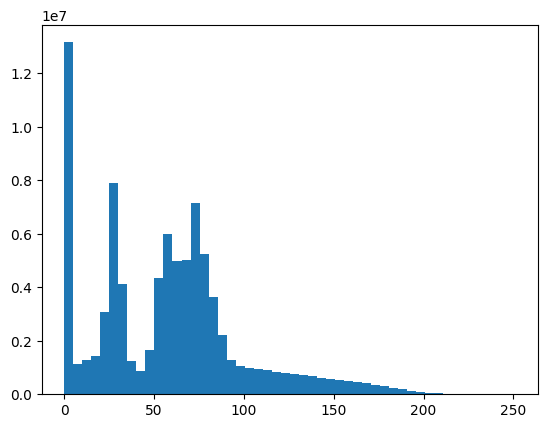

In [4]:
datapath='/home/aistudio/PaddleSeg/data/mine/' 
data=cv2.imread(datapath+'Image/0001.png',0)
for i in range(2,101):
        name = str(i).zfill(4)
        image = cv2.imread(datapath+'Image/'+name+'.png',0)
        data=np.concatenate((data,image),axis=1)
print(data.shape)
plt.hist(data.reshape(-1,),bins=50)
plt.show()

In [5]:
#给定windowing自定义函数
def windowing(img, window_width, window_center):
    #img： 需要增强的图片
    #window_width:窗宽
    #window_center:中心
    minWindow = float(window_center)-0.5*float(window_width)
    new_img = (img-minWindow)/float(window_width)
    new_img[new_img<0] = 0
    new_img[new_img>1] = 1
    return (new_img*255).astype('uint8') #把数据整理成标准图像格式

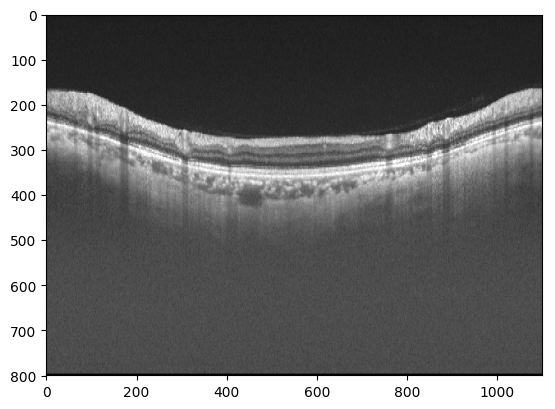

True

In [6]:
data1=cv2.imread(datapath+'Image/0001.png',0)
img_ct = windowing(data1,200,100)
plt.imshow(img_ct,cmap='gray')
plt.show()
cv2.imwrite("/home/aistudio/test.png",img_ct)

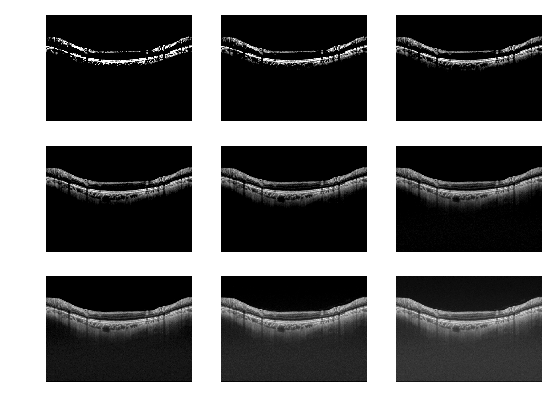

In [7]:
#依次增大图像的位宽，图像对比度降低。
#如果窗宽过低，部分低的像素会直接区分不出背景。所以对比度不能过高，也不能过低。
j = 1
data1=cv2.imread(datapath+'Image/0001.png',0)
for i in range(1,10):
    plt.subplot(3,3,j)
    img_ct = windowing(data1,i*30,150)
    plt.imshow(img_ct,cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

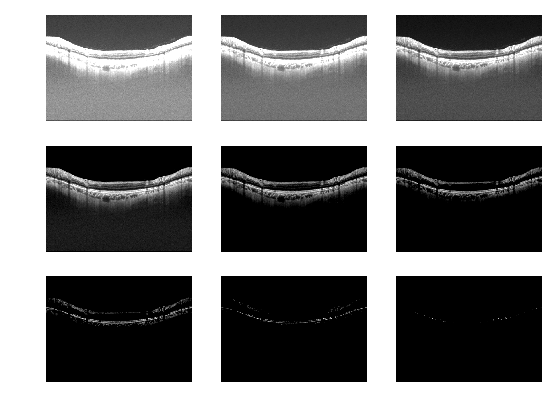

In [8]:
#依次增大图像的窗中心（窗位的另外一个叫法），亮度降低
j = 1
data1=cv2.imread(datapath+'Image/0001.png',0)
for i in range(1,10):
    plt.subplot(3,3,j)
    img_ct = windowing(data1,150,i*30)
    plt.imshow(img_ct,cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

In [9]:
!mkdir /home/aistudio/PaddleSeg/data/mine/image
class windowImg(object):
    def __init__(self,mode='train'):
        self.dataPath = '/home/aistudio/PaddleSeg/data/mine/'
        self.mode=mode
    def run(self):
        if self.mode=='train':
            for i in range(1,101):
                name = str(i).zfill(4)
                image = cv2.imread(self.dataPath+'Image/'+name+'.png',0)
                image = windowing(image,200,100)
                cv2.imwrite(self.dataPath+'image/'+name+'.png', image)
        elif self.mode=='test':
            for i in range(101,201):
                name = str(i).zfill(4)
                image = cv2.imread(self.dataPath+'Test/'+name+'.png',0)
                image = windowing(image,200,100)
                cv2.imwrite(self.dataPath+'test/'+name+'.png', image)
win = windowImg('train')
win.run()

In [14]:
!mkdir /home/aistudio/PaddleSeg/data/mine/Image_Label
class Pre(object):
    def __init__(self):
        self.dataPath = '/home/aistudio/PaddleSeg/data/mine/'
    def run(self):
        # 生成train.txt和valid.txt
        trainFile = open(self.dataPath + 'train.txt', 'w')
        vaildFile = open(self.dataPath + 'valid.txt', 'w')
        for i in range(1,101):
            name = str(i).zfill(4)
            if i <= 90:
                trainFile.write('image/'+name+'.png Image_Label/'+name+'.png')
                trainFile.write('\n')
            else:
                vaildFile.write('image/'+name+'.png Image_Label/'+name+'.png')
                vaildFile.write('\n')
            # 将标签图片转为标准标准图片
            image = cv2.imread(self.dataPath+'Layer_Masks/'+name+'.png')
            # 像素值为0的是RNFL(类别 0)
            # 像素值为80的是GCIPL(类别 1)
            # 像素值为160的是脉络膜(类别 2)
            # 像素值为255的是其他（类别3）。
            image[image == 80] = 1
            image[image == 160] = 2
            image[image == 255] = 3
            image = image[:,:,1]
            cv2.imwrite(self.dataPath+'Image_Label/'+name+'.png', image)
pre = Pre()
pre.run()

# 三.训练







## 模型

模型使用了早期的网络U-net。刚刚发现了官方baseline用的也是U net。这另一方面说明了图像类任务主要是预处理和后处理，比赛而言模型大部分时候不会改。

* 医学图像的语义较为简单，每一个部分都是人的很小一部分。不同的器官也会用不同的器械。器官本身结构固定，所以对于一个语义分割任务只有那么几类，不像是自动驾驶，室外场景会碰到各种不同的类别。进而高级语义信息和底层特征都很重要。这样就是U net的特点，高层特征和底层特征融合，这样网络兼顾两者。
* 数据量少。本数据只有100张图片，模型参数不宜多。

U net的结构如下图，是一个U型的结果。左右是encoder，包含若干的卷积、降采样层。右方是decoder上采样，同时会把左面的特征进行拼接。右侧反卷集，最后恢复到图像原始形状。

![](https://ai-studio-static-online.cdn.bcebos.com/e38367730dc04f989373528e3be00e8e6315850ee175457497791f69c3dfb1ea)





配置文件我已放到家目录下面，后面直接复制到对应路径，覆盖掉原始的配置文件。

首先是改了cityscapes,用于读取数据。
```
batch_size: 4
iters: 2000

train_dataset:
  type: Dataset
  dataset_root: data/mine
  train_path: data/mine/train.txt
  transforms:
    - type: ResizeStepScaling
      min_scale_factor: 0.5
      max_scale_factor: 2.0
      scale_step_size: 0.25
    - type: RandomPaddingCrop
      crop_size: [1024, 512]
    - type: RandomHorizontalFlip
    - type: RandomDistort
      brightness_range: 0.4
      contrast_range: 0.4
      saturation_range: 0.4
    - type: Normalize
  num_classes: 4
  mode: train

val_dataset:
  type: Dataset
  dataset_root: data/mine
  val_path: data/mine/valid.txt
  transforms:
    - type: Normalize
  num_classes: 4
  mode: val


optimizer:
  type: sgd
  momentum: 0.9
  weight_decay: 4.0e-5

lr_scheduler:
  type: PolynomialDecay
  learning_rate: 0.01
  end_lr: 0
  power: 0.9

loss:
  types:
    - type: CrossEntropyLoss
  coef: [1]
```

然后是修改了适配的模型yml

```
_base_: '../_base_/cityscapes.yml'

batch_size: 4
iters: 2000

model:
  type: UNet
  num_classes: 4
  use_deconv: False
  pretrained: Null

```



In [11]:
!cp /home/aistudio/unet_cityscapes_1024x512_160k.yml /home/aistudio/PaddleSeg/configs/unet
!cp /home/aistudio/cityscapes.yml /home/aistudio/PaddleSeg/configs/_base_


In [15]:
%cd /home/aistudio/PaddleSeg/

!export CUDA_VISIBLE_DEVICES=0 # 设置1张可用的卡

!python train.py \
       --config configs/unet/unet_cityscapes_1024x512_160k.yml \
       --save_interval 500 \
       --do_eval \
       --use_vdl \
       --save_dir output


/home/aistudio/PaddleSeg
2023-01-05 02:35:56 [INFO]	
------------Environment Information-------------
platform: Linux-4.15.0-140-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Build cuda_11.2.r11.2/compiler.29618528_0
cudnn: 8.2
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-16GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.6.0
PaddlePaddle: 2.3.2
OpenCV: 4.6.0
------------------------------------------------
2023-01-05 02:35:56 [INFO]	
---------------Config Information---------------
batch_size: 4
iters: 2000
loss:
  coef:
  - 1
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.01
  power: 0.9
  type: PolynomialDecay
model:
  num_classes: 4
  pretrained: null
  type: UNet
  use_deconv: false
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
train_dataset:
  dataset_root: data/mine
  mode: train


# 四.评估

In [16]:
!python val.py \
       --config configs/unet/unet_cityscapes_1024x512_160k.yml \
       --model_path output/best_model/model.pdparams

2023-01-05 02:59:13 [INFO]	
---------------Config Information---------------
batch_size: 4
iters: 2000
loss:
  coef:
  - 1
  types:
  - type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.01
  power: 0.9
  type: PolynomialDecay
model:
  num_classes: 4
  pretrained: null
  type: UNet
  use_deconv: false
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
train_dataset:
  dataset_root: data/mine
  mode: train
  num_classes: 4
  train_path: data/mine/train.txt
  transforms:
  - max_scale_factor: 2.0
    min_scale_factor: 0.5
    scale_step_size: 0.25
    type: ResizeStepScaling
  - crop_size:
    - 1024
    - 512
    type: RandomPaddingCrop
  - type: RandomHorizontalFlip
  - brightness_range: 0.4
    contrast_range: 0.4
    saturation_range: 0.4
    type: RandomDistort
  - type: Normalize
  type: Dataset
val_dataset:
  dataset_root: data/mine
  mode: val
  num_classes: 4
  transforms:
  - type: Normalize
  type: Dataset
  val_path: data/mine/valid.txt
----------

# 五.A榜图片

**需要注意的是，我们在前面数据增强使用了windowing方案，则推理时必须做同样的处理**

In [17]:
!mkdir /home/aistudio/PaddleSeg/data/mine/test
testWin = windowImg('test')
testWin.run()

In [18]:
!python predict.py \
       --config      configs/unet/unet_cityscapes_1024x512_160k.yml \
       --model_path output/best_model/model.pdparams \
       --image_path data/mine/test \
       --save_dir output/result \
       --custom_color 0 0 0 80 80 80 160 160 160 255 255 255


2023-01-05 02:59:38 [INFO]	
---------------Config Information---------------
batch_size: 4
iters: 2000
loss:
  coef:
  - 1
  types:
  - type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.01
  power: 0.9
  type: PolynomialDecay
model:
  num_classes: 4
  pretrained: null
  type: UNet
  use_deconv: false
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
train_dataset:
  dataset_root: data/mine
  mode: train
  num_classes: 4
  train_path: data/mine/train.txt
  transforms:
  - max_scale_factor: 2.0
    min_scale_factor: 0.5
    scale_step_size: 0.25
    type: ResizeStepScaling
  - crop_size:
    - 1024
    - 512
    type: RandomPaddingCrop
  - type: RandomHorizontalFlip
  - brightness_range: 0.4
    contrast_range: 0.4
    saturation_range: 0.4
    type: RandomDistort
  - type: Normalize
  type: Dataset
val_dataset:
  dataset_root: data/mine
  mode: val
  num_classes: 4
  transforms:
  - type: Normalize
  type: Dataset
  val_path: data/mine/valid.txt
----------

# 六.提交比赛结果





In [19]:
!rm -rf /home/aistudio/PaddleSeg/output/result/added_prediction
!mv /home/aistudio/PaddleSeg/output/result/pseudo_color_prediction Layer_Segmentations
!zip -r result.zip  /home/aistudio/PaddleSeg/output/result/
#最后提交文件即可。

  adding: home/aistudio/PaddleSeg/output/result/ (stored 0%)


# 七.总结

分数其实并没有超过前几个月的选手，主要是多了一个数据增强的方案。OCT是一个很热门的技术，作者在做脑部OCT的一些工作，主要是数据处理以及器械。OCT的图像采集是一个很重要的工作，本文的应用场景是眼，其实不仅仅是眼。脑部血管也可以用。最后希望自己能早日获取PPDE。

参考链接：

[飞桨学习赛：眼底OCT层分割（GOALS挑战赛任务一）第一名方案](https://aistudio.baidu.com/aistudio/projectdetail/4609530?channelType=0&channel=0)

[分割网络](https://aistudio.baidu.com/aistudio/projectdetail/2148971?channelType=0&channel=0)